## Hemorrhage Classification 
Hemorrhage in the head (intracranial hemorrhage) is a relatively common condition that has many causes ranging from trauma, stroke, aneurysm, vascular malformations, high blood pressure, illicit drugs and blood clotting disorders. The neurologic consequences also vary extensively depending upon the size, type of hemorrhage and location ranging from headache to death. The role of the Radiologist is to detect the hemorrhage, characterize the hemorrhage subtype, its size and to determine if the hemorrhage might be jeopardizing critical areas of the brain that might require immediate surgery.
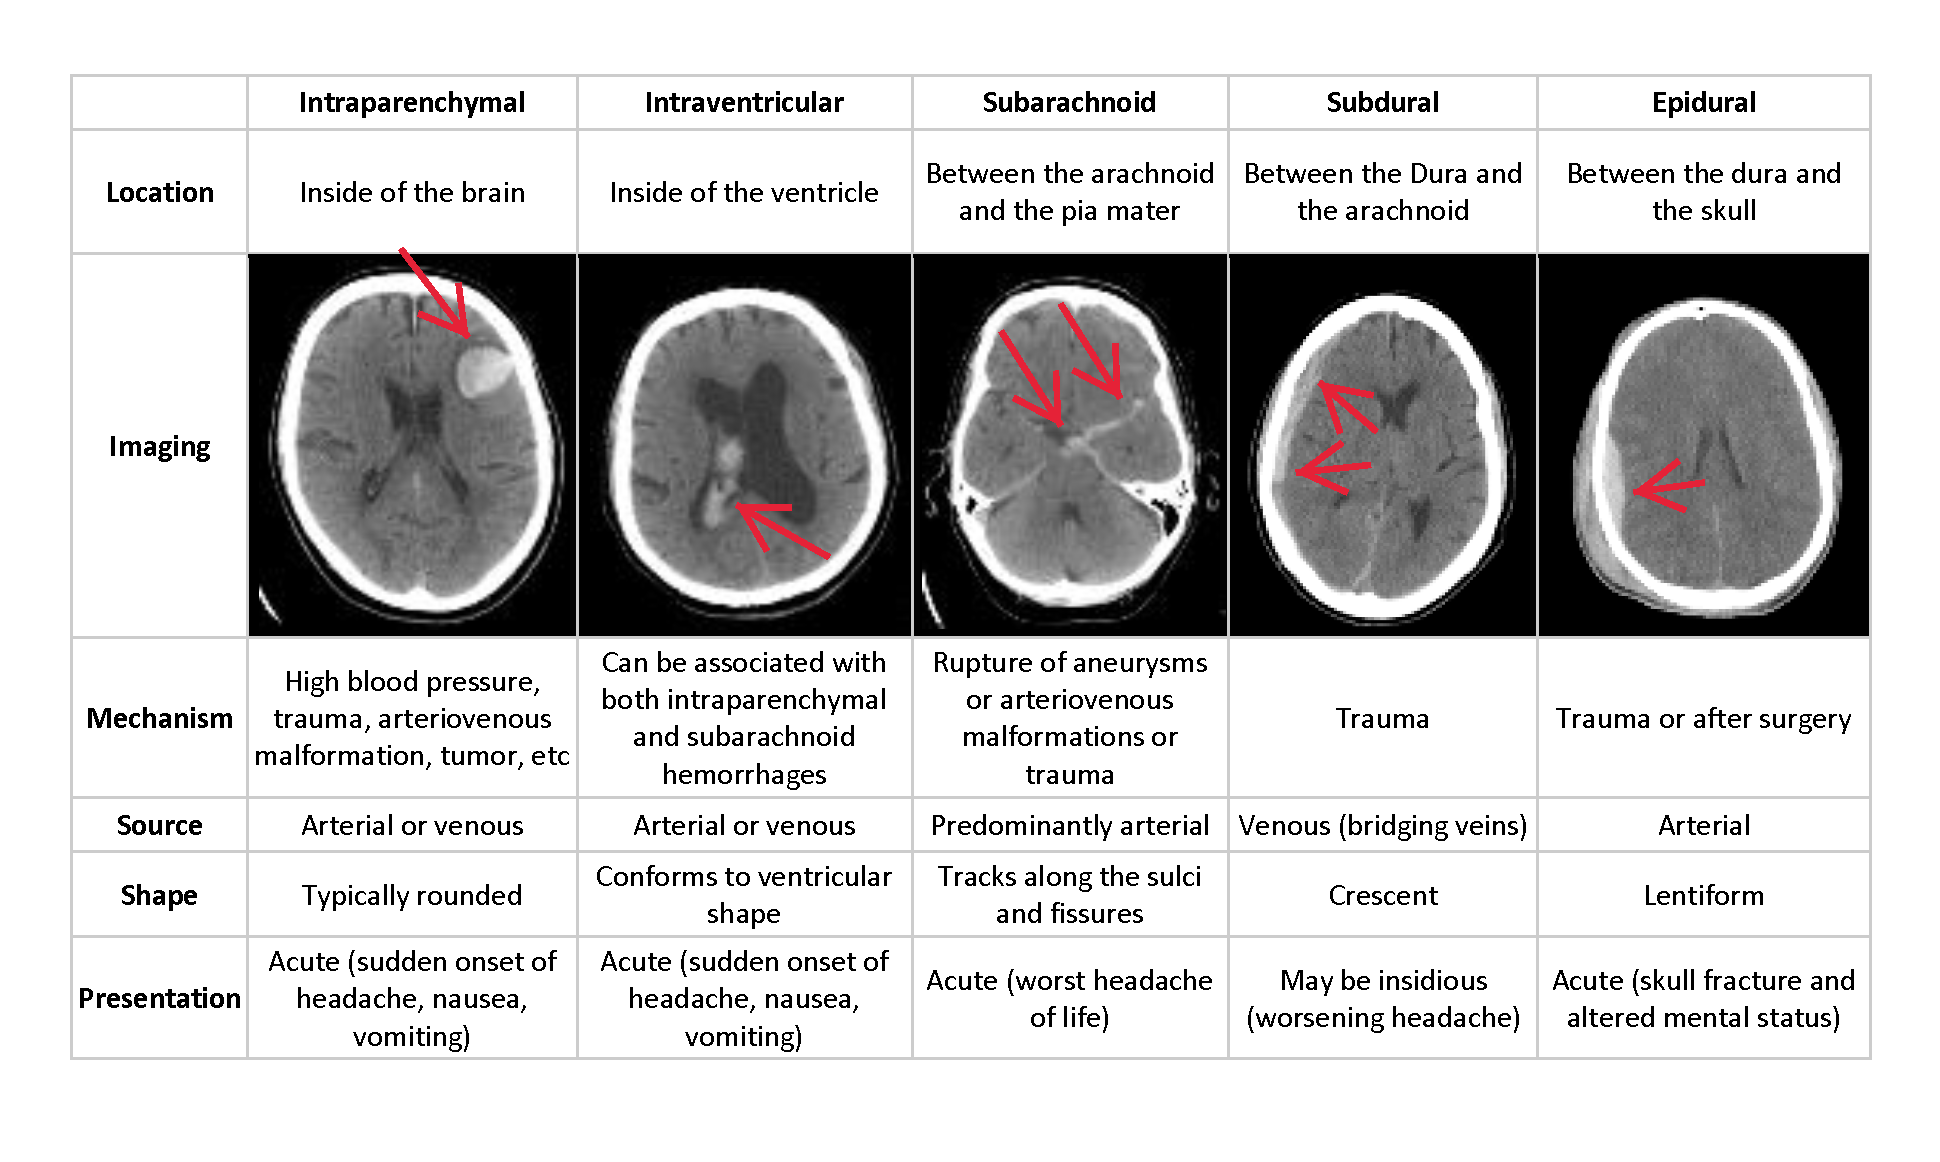

### Objective : Classify six categories of hemorrhage
* 1_epidural
* intraparenchymal
* intraventricular
* subarachnoid
* subdural
* any

#### Imports

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()


from sklearn.model_selection import ShuffleSplit

import pydicom
import cv2

import os
import time
import random as rand
from math import ceil, floor, log
from os import listdir
from os.path import isfile, join
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


from torch.utils.data import DataLoader, Dataset
from functools import partial

import torch
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#### Load Data
**stage_1_train.csv** - the training set. Contains Ids and target information. **stage_1_sample_submission.csv** - a sample submission file in the correct format. Contains Ids for the test set.

Stage 1 Images - **stage_1_train_images.zip** and **stage_1_test_images.zip**

In [2]:
# Read train data
train = pd.read_csv('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
train.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [3]:
# Read test data
test = pd.read_csv('/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')
test.head()

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5


In [4]:
# Images Example
train_images_dir = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]


In [42]:
test_images_dir = '/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/'
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]

In [5]:
# Total Images 
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 752803
Number of test images: 121232


#### EDA 

In [6]:
traindf = train.copy()
label = traindf.Label.values
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
subtype_counts = traindf.groupby("subtype").label.value_counts().unstack()
subtype_counts = subtype_counts.loc[:, 1] / traindf.groupby("subtype").size() * 100
traindf.head()

,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


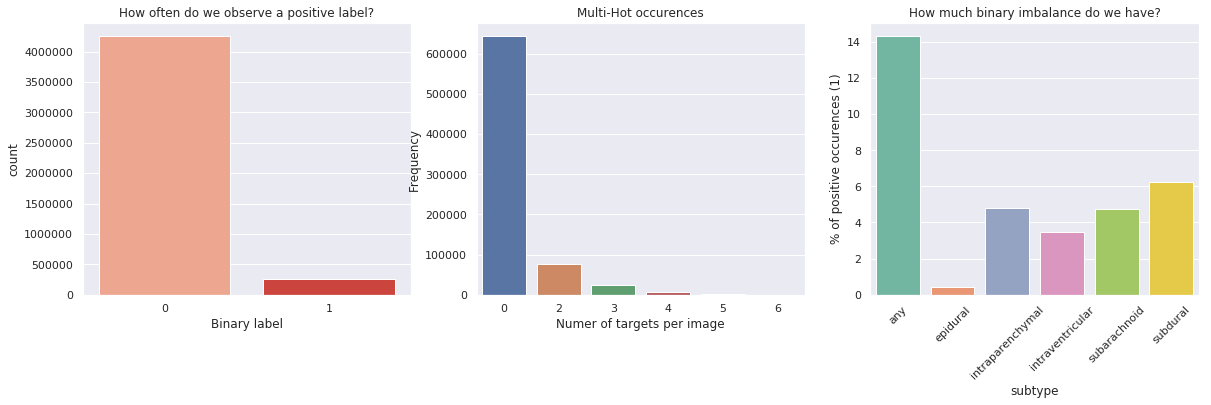

In [7]:
multi_target_count = traindf.groupby("id").label.sum()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.countplot(traindf.label, ax=ax[0], palette="Reds")
ax[0].set_xlabel("Binary label")
ax[0].set_title("How often do we observe a positive label?");

sns.countplot(multi_target_count, ax=ax[1])
ax[1].set_xlabel("Numer of targets per image")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Multi-Hot occurences")

sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=ax[2], palette="Set2")
plt.xticks(rotation=45); 
ax[2].set_title("How much binary imbalance do we have?")
ax[2].set_ylabel("% of positive occurences (1)");

* From the graph 1 we can infer that , Mostly all the values are non-positives and very few are positivies . 
* From the graph 3 we can infer that , there is a huge class imbalance 

#### Things given in dicom file

In [8]:
INPUT_PATH = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_dir = INPUT_PATH + "stage_2_train/"
dataset = pydicom.dcmread(train_dir + "ID_c5c23af94.dcm")
print(dataset)

(0008, 0018) SOP Instance UID                    UI: ID_c5c23af94
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_9630cc49'
(0020, 000d) Study Instance UID                  UI: ID_c5409f3ace
(0020, 000e) Series Instance UID                 UI: ID_5db30227b2
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000', '-118.882', '33.678']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.951057', '-0.309017']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored          

#### Windowing in CT Scans
Windowing, also known as grey-level mapping, contrast stretching, histogram modification or contrast enhancement is the process in which the CT image greyscale component of an image is manipulated via the CT numbers; doing this will change the appearance of the picture to highlight particular structures. The brightness of the image is, adjusted via the window level. The contrast is adjusted via the window width.

Window of a particular scan is measured using two components : ** Width (w) ** and ** Level (l) **

#### Window width
The window width (WW) as the name suggests is the measure of the range of CT numbers that an image contains.
A wider window width (2000 HU), therefore, will display a wider range of CT numbers. Consequently, the transition of dark to light structures will occur over a larger transition area to that of a narrow window width (<1000 HU).

#### Window level
The window level (WL), often also referred to as window centre, is the midpoint of the range of the CT numbers displayed.
When the window level is decreased the CT image will be brighter and vice versa.

There are at least 5 windows that a radiologist goes through for each scan!

* Brain Matter window : W:80 L:40
* Blood/subdural window: W:130-300 L:50-100
* Soft tissue window: W:350–400 L:20–60
* Bone window: W:2800 L:600
* Grey-white differentiation window: W:8 L:32 or W:40 L:40

Example:
Brain Matter window
L = 40
W = 80
Voxels displayed range from 0 to 80
( Lower limit = 40 - (80/2), upper limit = 40 + (80/2) )
Voxel values outside this range will be completely black or white.

Lot of windowing visualization kernels are available . After refering ,[Ryan Windowing Notebook]( https://www.kaggle.com/reppic/gradient-sigmoid-windowing ) , I planned to use ** Sigmoid (Brain + Subdural + Bone) Windowing **

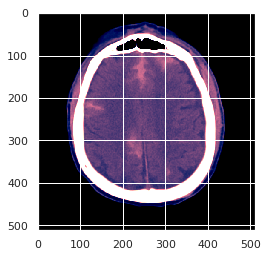

In [9]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

# BSB Window
def bsb_window(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb(img):
    brain_img = bsb_window(img, 40, 80)
    subdural_img = bsb_window(img, 80, 200)
    soft_img = bsb_window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

dicom = pydicom.dcmread(train_images_dir + 'ID_5c8b5d701' + '.dcm')

plt.imshow(bsb(dicom), cmap=plt.cm.bone);

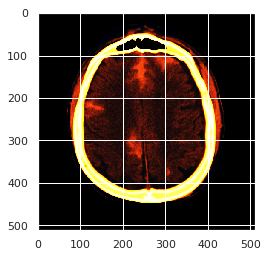

In [10]:
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def sigmoid_window(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    _, _, intercept, slope = get_windowing(img)
    img = img.pixel_array * slope + intercept
    ue = np.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

# Sigmoid (BSB)
def sigmoid_bsb_window(img):
    brain_img = sigmoid_window(img, 40, 80)
    subdural_img = sigmoid_window(img, 80, 200)
    bone_img = sigmoid_window(img, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

dicom = pydicom.dcmread(train_images_dir + 'ID_5c8b5d701' + '.dcm')

plt.imshow(sigmoid_bsb_window(dicom), cmap=plt.cm.bone);

Comparing the default and sigmoid window ,

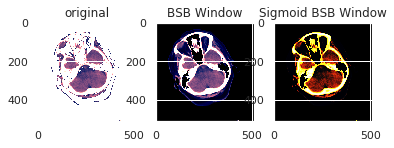

In [11]:
def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_036db39b7" + ".dcm")

fig, ax = plt.subplots(1, 3)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(bsb(dicom) , cmap=plt.cm.bone);
ax[1].set_title("BSB Window");
ax[2].imshow(sigmoid_bsb_window(dicom) , cmap=plt.cm.bone);
ax[2].set_title("Sigmoid BSB Window");


After getting which window to use , prepare the dicom files to 3-channel images using some helper functions

1 .** DICOM to Image **

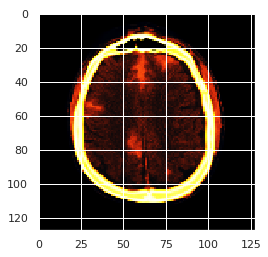

In [41]:
def _read(path, desired_size = (224, 224, 3)):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        # Using Sigmoid BSB Window
        img = sigmoid_bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+'ID_5c8b5d701'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

2. ** Dataset & DataLoader **

In [13]:
train.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [14]:
def read_testset(df):

    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(df):

    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    duplicates_to_remove = [
        1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
        312468,  312469,  312470,  312471,  312472,  312473,
        2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
        3032994, 3032995, 3032996, 3032997, 3032998, 3032999
    ]
    
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.drop_duplicates()
#     df = df.reset_index(drop=True)
    df = df.set_index(['Image', 'Diagnosis'] ).unstack(level=-1)
    
    return df

    
df = read_trainset( train )
test_df = read_testset( test )

In [15]:
df.head(20)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
ID_0000aee4b     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_000178e76     0        0                0                0            0   
ID_00019828f     0        0                0                0            0   
ID_0001dcc25     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
ID_0001f7f62     0        0                0                0            0   
ID_0002003a8     0        0                0                0            0   
ID_0002081b6     1        0                1                0            0   
ID_0002108bd     0        0                0                0            0   
ID_000229f2a     0        0                0                0            0   
ID_000230ed7     0        0                0                0            0   
ID_000259ccf     0        0                0                0            0   
ID_00025ef4b     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
ID_0000aee4b        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_000178e76        0  
ID_00019828f        0  
ID_0001dcc25        0  
ID_0001de0e8        0  
ID_0001f7f62        0  
ID_0002003a8        0  
ID_0002081b6        0  
ID_0002108bd        0  
ID_000229f2a        0  
ID_000230ed7        0  
ID_000259ccf        0  
ID_00025ef4b        0

In [16]:
test_df.head()

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   
ID_000134952   0.5      0.5              0.5              0.5          0.5   
ID_000176f2a   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5  
ID_000134952      0.5  
ID_000176f2a      0.5

In [17]:
class Image_Dataset(Dataset):
    def __init__(self, list_IDs, labels=None, img_size=(512, 512, 1), 
                 img_dir=train_images_dir, *args, **kwargs):
        self.list_IDs = list_IDs
        self.labels = labels
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))
            
    def __len__(self):
        return int(ceil(len(self.indices)))
    
    def __getitem__(self, index):
        indices = self.indices[index:(index+1)]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((1, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((1, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
            
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X


In [18]:
# train set (90%) and validation set (10%)
ss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)

train_df = df.iloc[train_idx]
val_df = df.iloc[valid_idx]

In [19]:
val_df = val_df[:1000]

In [20]:
# Train Dataset
input_dims = (224, 224, 3)
train_dataset = Image_Dataset(train_df.index, train_df, input_dims , train_images_dir)

# Val Dataset
val_dataset = Image_Dataset(val_df.index, val_df, input_dims , train_images_dir)

In [21]:
# Creating Train DataLoader
train_dataloader = DataLoader(train_dataset,shuffle = False,batch_size = 64)

# Creating Test DataLoader
val_dataloader = DataLoader(val_dataset,shuffle = False,batch_size = 16)

3.a ** Model **

In [22]:
class OctConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 alpha_in=0.25, alpha_out=0.25, type='normal'):
        super(OctConv, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.type = type
        hf_ch_in = int(in_channels * (1 - alpha_in))
        hf_ch_out = int(out_channels * (1 - alpha_out))
        lf_ch_in = in_channels - hf_ch_in
        lf_ch_out = out_channels - hf_ch_out

        if type == 'first':
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)
            self.convh = nn.Conv2d(
                in_channels, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding,
            )
            self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
            self.convl = nn.Conv2d(
                in_channels, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding,
            )
        elif type == 'last':
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)
            self.convh = nn.Conv2d(hf_ch_in, out_channels, kernel_size=kernel_size, padding=padding)
            self.convl = nn.Conv2d(lf_ch_in, out_channels, kernel_size=kernel_size, padding=padding)
            self.upsample = partial(F.interpolate, scale_factor=2, mode="nearest")
        else:
            if stride == 2:
                self.downsample = nn.AvgPool2d(kernel_size=2, stride=stride)

            self.L2L = nn.Conv2d(
                lf_ch_in, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.L2H = nn.Conv2d(
                lf_ch_in, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.H2L = nn.Conv2d(
                hf_ch_in, lf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.H2H = nn.Conv2d(
                hf_ch_in, hf_ch_out,
                kernel_size=kernel_size, stride=1, padding=padding
            )
            self.upsample = partial(F.interpolate, scale_factor=2, mode="nearest")
            self.avg_pool = partial(F.avg_pool2d, kernel_size=2, stride=2)

    def forward(self, x):
        if self.type == 'first':
            if self.stride == 2:
                x = self.downsample(x)

            hf = self.convh(x)
            lf = self.avg_pool(x)
            lf = self.convl(lf)

            return hf, lf
        elif self.type == 'last':
            hf, lf = x
            if self.stride == 2:
                hf = self.downsample(hf)
                return self.convh(hf) + self.convl(lf)
            else:
                return self.convh(hf) + self.convl(self.upsample(lf))
        else:
            hf, lf = x
            if self.stride == 2:
                hf = self.downsample(hf)
                return self.H2H(hf) + self.L2H(lf), \
                       self.L2L(F.avg_pool2d(lf, kernel_size=2, stride=2)) + self.H2L(self.avg_pool(hf))
            else:
                return self.H2H(hf) + self.upsample(self.L2H(lf)), self.L2L(lf) + self.H2L(self.avg_pool(hf))


def norm_conv3x3(in_planes, out_planes, stride=1, type=None):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def norm_conv1x1(in_planes, out_planes, stride=1, type=None):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def oct_conv3x3(in_planes, out_planes, stride=1, type='normal'):
    """3x3 convolution with padding"""
    return OctConv(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, type=type)


def oct_conv1x1(in_planes, out_planes, stride=1, type='normal'):
    """1x1 convolution"""
    return OctConv(in_planes, out_planes, kernel_size=1, stride=stride, type=type)


class _BatchNorm2d(nn.Module):
    def __init__(self, num_features, alpha_in=0.25, alpha_out=0.25, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_BatchNorm2d, self).__init__()
        hf_ch = int(num_features * (1 - alpha_in))
        lf_ch = num_features - hf_ch
        self.bnh = nn.BatchNorm2d(hf_ch)
        self.bnl = nn.BatchNorm2d(lf_ch)

    def forward(self, x):
        hf, lf = x
        return self.bnh(hf), self.bnl(lf)


class _ReLU(nn.ReLU):
    def forward(self, x):
        hf, lf = x
        hf = super(_ReLU, self).forward(hf)
        lf = super(_ReLU, self).forward(lf)
        return hf, lf


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, type="normal", oct_conv_on=True):
        super(BasicBlock, self).__init__()
        conv3x3 = oct_conv3x3 if oct_conv_on else norm_conv3x3
        norm_func = _BatchNorm2d if oct_conv_on else nn.BatchNorm2d
        act_func = _ReLU if oct_conv_on else nn.ReLU
        

        self.conv1 = conv3x3(inplanes, planes, type="first" if type == "first" else "normal")
        self.bn1 = norm_func(planes)
        self.relu1 = act_func(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride, type="last" if type == "last" else "normal")
        if type == "last":
            norm_func = nn.BatchNorm2d
            act_func = nn.ReLU
        self.bn2 = norm_func(planes)
        self.relu2 = act_func(inplace=True)
        self.downsample = downsample
        self.stride = stride
        
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if isinstance(out, (tuple, list)):
            assert len(out) == len(identity) and len(out) == 2
            out = (out[0] + identity[0], out[1] + identity[1])
        else:
            out += identity

        out = self.relu2(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, type="normal", oct_conv_on=True):
        super(Bottleneck, self).__init__()
        conv1x1 = oct_conv1x1 if oct_conv_on else norm_conv1x1
        conv3x3 = oct_conv3x3 if oct_conv_on else norm_conv3x3
        norm_func = _BatchNorm2d if oct_conv_on else nn.BatchNorm2d
        act_func = _ReLU if oct_conv_on else nn.ReLU

        self.conv1 = conv1x1(inplanes, planes, type="first" if type == "first" else "normal")
        self.bn1 = norm_func(planes)
        self.relu1 = act_func(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride, type="last" if type == "last" else "normal")
        if type == "last":
            conv1x1 = norm_conv1x1
            norm_func = nn.BatchNorm2d
            act_func = nn.ReLU
        self.bn2 = norm_func(planes)
        self.relu2 = act_func(inplace=True)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = norm_func(planes * self.expansion)
        self.relu3 = act_func(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        if isinstance(out, (tuple, list)):
            assert len(out) == len(identity) and len(out) == 2
            out = (out[0] + identity[0], out[1] + identity[1])
        else:
            out += identity
        out = self.relu3(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=6, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], type="first")
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, type="last")
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, type="normal"):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or type=='first':
            norm_func = nn.BatchNorm2d if type == "last" else _BatchNorm2d
            downsample = nn.Sequential(
                oct_conv1x1(self.inplanes, planes * block.expansion, stride, type=type),
                norm_func(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, type=type))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, oct_conv_on=type != "last"))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.squeeze()
        shape = x.shape
        x = torch.reshape(x,(shape[0],3,224,224))
        x = x.float()
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [23]:
def octave_resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    return model

4. ** Model Definition , Loss , Optimizer and scheduler **

In [24]:
# Use GPU
use_gpu = torch.cuda.is_available()

# Declare the mode
model = octave_resnet152 ()

# criterion 
criterion = nn.PoissonNLLLoss()

if use_gpu:
    model = model.cuda()
    criterion = criterion.cuda()
    
# Optimizer 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Scheduler 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

5. ** Training Function **

In [25]:
# Training Function 
def train(model, criterion, optimizer, scheduler, dataloader, use_gpu, num_epochs=20):
    print("Training Initiated")
    since = time.time()
    steps = 0
    model.train(True)
    
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        
        for data in dataloader:
            
            steps += 1
            inputs, labels = data
            if use_gpu:
                inputs = inputs
                labels = labels
                
                inputs = inputs.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            
            # compute output
            outputs = model(inputs)
            #labels = labels.long()
            labels = labels.squeeze_()
            outputs = outputs.squeeze()
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            
            # add the current loss to running loss
            running_loss += loss.item()
            
            # Compute gradient and do SGD step
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            print("< -------- Train Step:{} -------- >".format(steps))
            if steps % 100 == 0:
                model.eval()
                validation_loss = 0
                accuracy = 0
                print("------ Validation Initiated ------------")
                for i,(inputs,labels) in enumerate(val_dataloader):
                    optimizer.zero_grad()
                    inputs, labels = inputs.to('cuda') , labels.to('cuda')
                    with torch.no_grad():
                        outputs = model(inputs)
                        #labels = labels.long()
                        labels = labels.squeeze_()
                        outputs = outputs.squeeze()
                        labels = labels.squeeze()
                        validation_loss = criterion(outputs,labels)
#                         ps = torch.exp(outputs).data
#                         print("Labels Shape",labels.shape)
#                         print("Ps shape",ps.shape)
#                         equality = (labels.data == ps.max(1)[1])
#                         accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                val_loss = validation_loss / len(val_dataloader)
                
                print("Epoch: {}/{}... | ".format(epoch+1, num_epochs),
                      "Loss: {:.4f} | ".format(running_loss/100),
                      "Validation Loss {:.4f} | ".format(val_loss))
                
#                 if train_ac > best_acc :
#                     best_acc = train_ac
#                     print("------------ Saving Best Model -----------")
#                     torch.save(model.state_dict(),"models_best.pth")

                running_loss = 0

In [26]:
# try:
#     train(model, criterion, optimizer, exp_lr_scheduler, train_dataloader, use_gpu,
#                        num_epochs=50)
# except:
#     torch.save(model.state_dict(),"model_error.pth")

In [27]:
train(model, criterion, optimizer, exp_lr_scheduler, train_dataloader, use_gpu,
                       num_epochs=50)

Training Initiated
------------------------- Train Step: 1
------------------------- Train Step: 2
------------------------- Train Step: 3
------------------------- Train Step: 4
------------------------- Train Step: 5
------------------------- Train Step: 6
------------------------- Train Step: 7
------------------------- Train Step: 8
------------------------- Train Step: 9
------------------------- Train Step: 10
------------------------- Train Step: 11
------------------------- Train Step: 12
------------------------- Train Step: 13
------------------------- Train Step: 14
------------------------- Train Step: 15
------------------------- Train Step: 16
------------------------- Train Step: 17
------------------------- Train Step: 18
------------------------- Train Step: 19
------------------------- Train Step: 20
------------------------- Train Step: 21
------------------------- Train Step: 22
------------------------- Train Step: 23
------------------------- Train Step: 24
------

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in power


------------------------- Train Step: 88
------------------------- Train Step: 89
------------------------- Train Step: 90
------------------------- Train Step: 91
------------------------- Train Step: 92
------------------------- Train Step: 93
------------------------- Train Step: 94
------------------------- Train Step: 95
------------------------- Train Step: 96
------------------------- Train Step: 97
------------------------- Train Step: 98
------------------------- Train Step: 99
------------------------- Train Step: 100
------ Validation Initiated ------------
Epoch: 1/50... |  Loss: 1.3665 |  Validation Loss 0.0005 | 
------------------------- Train Step: 101
------------------------- Train Step: 102
------------------------- Train Step: 103
------------------------- Train Step: 104
------------------------- Train Step: 105
------------------------- Train Step: 106
------------------------- Train Step: 107
------------------------- Train Step: 108
------------------------- Tra

------------------------- Train Step: 279
------------------------- Train Step: 280
------------------------- Train Step: 281
------------------------- Train Step: 282
------------------------- Train Step: 283
------------------------- Train Step: 284
------------------------- Train Step: 285
------------------------- Train Step: 286
------------------------- Train Step: 287
------------------------- Train Step: 288
------------------------- Train Step: 289
------------------------- Train Step: 290
------------------------- Train Step: 291
------------------------- Train Step: 292
------------------------- Train Step: 293
------------------------- Train Step: 294
------------------------- Train Step: 295
------------------------- Train Step: 296
------------------------- Train Step: 297
------------------------- Train Step: 298
------------------------- Train Step: 299
------------------------- Train Step: 300
------ Validation Initiated ------------
Epoch: 1/50... |  Loss: 1.3409 |  V

------------------------- Train Step: 470
------------------------- Train Step: 471
------------------------- Train Step: 472
------------------------- Train Step: 473
------------------------- Train Step: 474
------------------------- Train Step: 475
------------------------- Train Step: 476
------------------------- Train Step: 477
------------------------- Train Step: 478
------------------------- Train Step: 479
------------------------- Train Step: 480
------------------------- Train Step: 481
------------------------- Train Step: 482
------------------------- Train Step: 483
------------------------- Train Step: 484
------------------------- Train Step: 485
------------------------- Train Step: 486
------------------------- Train Step: 487
------------------------- Train Step: 488
------------------------- Train Step: 489
------------------------- Train Step: 490
------------------------- Train Step: 491
------------------------- Train Step: 492
------------------------- Train St

------------------------- Train Step: 661
------------------------- Train Step: 662
------------------------- Train Step: 663
------------------------- Train Step: 664
------------------------- Train Step: 665
------------------------- Train Step: 666
------------------------- Train Step: 667
------------------------- Train Step: 668
------------------------- Train Step: 669
------------------------- Train Step: 670
------------------------- Train Step: 671
------------------------- Train Step: 672
------------------------- Train Step: 673
------------------------- Train Step: 674
------------------------- Train Step: 675
------------------------- Train Step: 676
------------------------- Train Step: 677
------------------------- Train Step: 678
------------------------- Train Step: 679
------------------------- Train Step: 680
------------------------- Train Step: 681
------------------------- Train Step: 682
------------------------- Train Step: 683
------------------------- Train St

------------------------- Train Step: 852
------------------------- Train Step: 853
------------------------- Train Step: 854
------------------------- Train Step: 855
------------------------- Train Step: 856
------------------------- Train Step: 857
------------------------- Train Step: 858
------------------------- Train Step: 859
------------------------- Train Step: 860
------------------------- Train Step: 861
------------------------- Train Step: 862
------------------------- Train Step: 863
------------------------- Train Step: 864
------------------------- Train Step: 865
------------------------- Train Step: 866
------------------------- Train Step: 867
------------------------- Train Step: 868
------------------------- Train Step: 869
------------------------- Train Step: 870
------------------------- Train Step: 871
------------------------- Train Step: 872
------------------------- Train Step: 873
------------------------- Train Step: 874
------------------------- Train St

------------------------- Train Step: 1042
------------------------- Train Step: 1043
------------------------- Train Step: 1044
------------------------- Train Step: 1045
------------------------- Train Step: 1046
------------------------- Train Step: 1047
------------------------- Train Step: 1048
------------------------- Train Step: 1049
------------------------- Train Step: 1050
------------------------- Train Step: 1051
------------------------- Train Step: 1052
------------------------- Train Step: 1053
------------------------- Train Step: 1054
------------------------- Train Step: 1055
------------------------- Train Step: 1056
------------------------- Train Step: 1057
------------------------- Train Step: 1058
------------------------- Train Step: 1059
------------------------- Train Step: 1060
------------------------- Train Step: 1061
------------------------- Train Step: 1062
------------------------- Train Step: 1063
------------------------- Train Step: 1064
-----------

------------------------- Train Step: 1228
------------------------- Train Step: 1229
------------------------- Train Step: 1230
------------------------- Train Step: 1231
------------------------- Train Step: 1232
------------------------- Train Step: 1233
------------------------- Train Step: 1234
------------------------- Train Step: 1235
------------------------- Train Step: 1236
------------------------- Train Step: 1237
------------------------- Train Step: 1238
------------------------- Train Step: 1239
------------------------- Train Step: 1240
------------------------- Train Step: 1241
------------------------- Train Step: 1242
------------------------- Train Step: 1243
------------------------- Train Step: 1244
------------------------- Train Step: 1245
------------------------- Train Step: 1246
------------------------- Train Step: 1247
------------------------- Train Step: 1248
------------------------- Train Step: 1249
------------------------- Train Step: 1250
-----------

------------------------- Train Step: 1414
------------------------- Train Step: 1415
------------------------- Train Step: 1416
------------------------- Train Step: 1417
------------------------- Train Step: 1418
------------------------- Train Step: 1419
------------------------- Train Step: 1420
------------------------- Train Step: 1421
------------------------- Train Step: 1422
------------------------- Train Step: 1423
------------------------- Train Step: 1424
------------------------- Train Step: 1425
------------------------- Train Step: 1426
------------------------- Train Step: 1427
------------------------- Train Step: 1428
------------------------- Train Step: 1429
------------------------- Train Step: 1430
------------------------- Train Step: 1431
------------------------- Train Step: 1432
------------------------- Train Step: 1433
------------------------- Train Step: 1434
------------------------- Train Step: 1435
------------------------- Train Step: 1436
-----------

KeyboardInterrupt: 

In [29]:
print("<------------ Saving Model ----------->")
torch.save(model.state_dict(),"models.pth")

<------------ Saving Model ----------->


In [52]:
# Loading Model
infer_model = octave_resnet152 ()
infer_model.load_state_dict(torch.load("models.pth"))
infer_model.to('cuda')
infer_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): OctConv(
        (convh): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1))
        (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (convl): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn1): _BatchNorm2d(
        (bnh): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bnl): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu1): _ReLU(inplace=True)
      (conv2): OctConv(
        (L2L): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (L2H): Conv2d(16, 48, kernel_size=(3, 3), stride

In [65]:
# Randomly select samples for testing
count = 5

test_dicom = rand.choices(test_images, k = count )

INPUT_PATH = "/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
test_dir = INPUT_PATH + "stage_2_test/"
test_img_path = [os.path.join(test_dir,x) for x in test_dicom]
test_imgs = list(map(_read, test_img_path))

# Convert the array images to tensor
test_imgs = np.array(test_imgs)
test_imgs = torch.from_numpy(test_imgs).to('cuda')

In [66]:
# Predict its distribution
labels = infer_model(test_imgs)

In [67]:
labels = labels.detach()
print(labels)

tensor([[  -8.9745,  -13.0812,   -5.7568, -237.1160,   -5.4742,   -9.7424],
        [  -3.7733,   -6.4000,   -4.0096,  -79.6587,   -3.8239,   -5.2594],
        [  -7.4656,  -11.3393,   -5.5461, -193.2266,   -5.1099,   -8.5923],
        [  -4.2950,   -6.9910,   -4.2722,  -93.6121,   -3.9292,   -5.6627],
        [  -3.8264,   -6.4773,   -4.0809,  -80.8856,   -3.7725,   -5.2459]],
       device='cuda:0')
